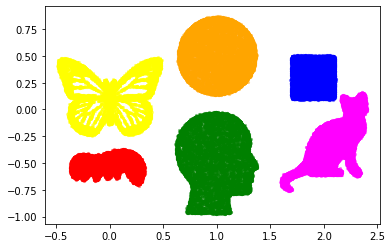

In [65]:
from IPython.display import clear_output
import pdb, time, math, numpy as np, gc, importlib, torch, os, cv2 as cv, ODEModel, matplotlib
import ot
import matplotlib.pyplot as plt
from torch import Tensor, nn
from torch.nn import functional as F 
from torch.autograd import Variable
from torch.distributions import MultivariateNormal
from torchdiffeq import odeint_adjoint as odeint 
from geomloss import SamplesLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import Utils, LearnVelTraj
importlib.reload(Utils)
from Utils import InputMapping, BoundingBox, ImageDataset, SaveTrajectory, ezshow, SaveTrajectory as st, MiscTransforms
importlib.reload(ODEModel)
from ODEModel import velocMLP, FfjordModel
importlib.reload(LearnVelTraj);
from LearnVelTraj import learn_vel_trajectory

im1 = ImageDataset('frames/butterfly.jpg'); 
im1b = ImageDataset('frames/butterflyfilled.jpg'); 
im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
im3 = ImageDataset('frames/circle.jpeg'); 
im4 = ImageDataset('frames/baldhead.jpeg'); 
im5 = ImageDataset('frames/square.png'); 
im6 = ImageDataset('frames/cat1.png'); 

n_inner = 7000;
n_sil = 10000 - n_inner;
d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [0.05, -.5]); 
d1a = im1.sample(n_inner, n_sil, center = [0, 0]); 
d1b = im1b.sample(n_inner, n_sil, center = [0, 0]); 
d3 = im3.sample(n_inner, n_sil, center = [1, .5]); 
d4 = im4.sample(n_inner, n_sil, center = [1, -.5]); 
d5 = im5.sample(n_inner, n_sil, center = [1.9, .3]); 
d6 = im6.sample(n_inner, n_sil, center = [2, -.3]); 

dat1 = torch.cat((d1a[0], d1b[1]),0)
dat2 = torch.cat(d2,0)
dat3 = torch.cat(d3,0)
dat4 = torch.cat(d4,0)
dat5 = torch.cat(d5,0)
dat6 = torch.cat(d6,0)

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')
ezshow(dat5, col='blue')
ezshow(dat6, col='magenta')

In [66]:
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=20, cycle=True)

In [55]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2, dat1)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_sinkhorn_scaling_radial/"
model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)


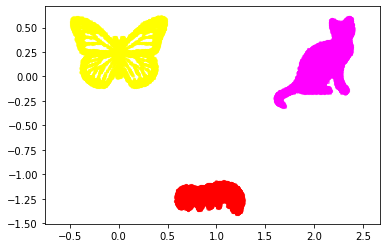

In [54]:
im1 = ImageDataset('frames/butterfly.jpg'); 
im1b = ImageDataset('frames/butterflyfilled.jpg'); 
im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
im6 = ImageDataset('frames/cat1.png'); 

n_inner = 7000;
n_sil = 10000 - n_inner;
d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [1, -1.2]); 
d1a = im1.sample(n_inner, n_sil, center = [0, .13]); 
d1b = im1b.sample(n_inner, n_sil, center = [0, .13]); 
d6 = im6.sample(n_inner, n_sil, center = [2, .15]); 

dat1 = torch.cat((d1a[0], d1b[1]),0)
dat2 = torch.cat(d2,0)
dat6 = torch.cat(d6,0)

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat6, col='magenta')

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<08:37,  1.73s/it]

Allocated: 0.04 GB  Reserved: 0.95 GB
[Loss: 1.6068 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.7319 | Iter: 1.7304 | fit: 0.2640 | reg: 0.1969 | save: 0.0000) | autograd: 1.2656]


 17%|█▋        | 51/300 [01:46<22:04,  5.32s/it]

Allocated: 0.04 GB  Reserved: 0.96 GB
[Loss: 0.2487 | lr: 0.0001 | n_subsample: 378] 
[Total time : 106.5122 | Iter: 94.8397 | fit: 0.3773 | reg: 0.2642 | save: 9.9394) | autograd: 1.6427]


 34%|███▎      | 101/300 [03:49<17:18,  5.22s/it]

Allocated: 0.05 GB  Reserved: 0.97 GB
[Loss: 0.1329 | lr: 0.0001 | n_subsample: 476] 
[Total time : 229.9612 | Iter: 113.7798 | fit: 0.3333 | reg: 0.2969 | save: 9.6678) | autograd: 1.6715]


 50%|█████     | 151/300 [05:55<12:54,  5.20s/it]

Allocated: 0.05 GB  Reserved: 0.97 GB
[Loss: 0.1238 | lr: 0.0001 | n_subsample: 600] 
[Total time : 355.2040 | Iter: 115.6385 | fit: 0.3516 | reg: 0.2930 | save: 9.6022) | autograd: 1.7191]


 67%|██████▋   | 201/300 [08:03<08:47,  5.33s/it]

Allocated: 0.05 GB  Reserved: 0.97 GB
[Loss: 0.0984 | lr: 5e-05 | n_subsample: 756] 
[Total time : 483.4506 | Iter: 118.4659 | fit: 0.3879 | reg: 0.3022 | save: 9.7797) | autograd: 1.7807]


 84%|████████▎ | 251/300 [10:16<04:21,  5.34s/it]

Allocated: 0.05 GB  Reserved: 0.97 GB
[Loss: 0.0869 | lr: 5e-05 | n_subsample: 953] 
[Total time : 616.1514 | Iter: 122.8978 | fit: 0.3786 | reg: 0.3317 | save: 9.8022) | autograd: 1.7436]


100%|██████████| 300/300 [12:44<00:00,  2.55s/it]

Allocated: 0.05 GB  Reserved: 0.97 GB
[Loss: 0.0785 | lr: 5e-05 | n_subsample: 953] 
[Total time : 764.3106 | Iter: 131.2372 | fit: 0.4627 | reg: 0.4124 | save: 16.9205) | autograd: 2.3690]


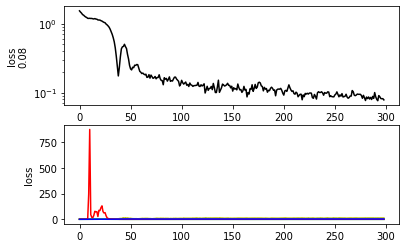

In [21]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2, dat1)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 4, in_features=3, out_features=2, incrementalMask = True,  Tperiod = len(keyframes)-1).to(device)
outfolder = "results/experiment_sinkhorn_scaling_radial/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)


  0%|          | 1/900 [00:01<20:20,  1.36s/it]

Allocated: 0.06 GB  Reserved: 0.72 GB
[Loss: 1.4912 | lr: 0.0006 | n_subsample: 300] 
[Total time : 1.3594 | Iter: 1.3577 | fit: 0.1978 | reg: 0.1367 | save: 0.0000) | autograd: 1.0202]



  6%|▌         | 51/900 [01:34<52:31,  3.71s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.8844 | lr: 0.0006 | n_subsample: 378] 
[Total time : 94.4543 | Iter: 87.2371 | fit: 0.2777 | reg: 0.2569 | save: 5.8562) | autograd: 1.3721]



 11%|█         | 101/900 [03:13<45:48,  3.44s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3917 | lr: 0.0006 | n_subsample: 476] 
[Total time : 193.1410 | Iter: 93.2924 | fit: 0.2692 | reg: 0.2148 | save: 5.3930) | autograd: 1.4166]



 17%|█▋        | 151/900 [04:51<42:35,  3.41s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.4088 | lr: 0.0006 | n_subsample: 600] 
[Total time : 291.3651 | Iter: 92.7176 | fit: 0.2677 | reg: 0.2259 | save: 5.5050) | autograd: 1.3375]



 22%|██▏       | 201/900 [06:27<41:17,  3.54s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.2787 | lr: 0.0006 | n_subsample: 756] 
[Total time : 387.9239 | Iter: 91.0200 | fit: 0.2840 | reg: 0.2311 | save: 5.5358) | autograd: 1.4010]



 28%|██▊       | 251/900 [08:07<37:21,  3.45s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.2480 | lr: 0.0006 | n_subsample: 953] 
[Total time : 487.5659 | Iter: 94.1727 | fit: 0.2698 | reg: 0.2014 | save: 5.4679) | autograd: 1.2769]



 33%|███▎      | 301/900 [09:48<35:45,  3.58s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.2786 | lr: 0.0006 | n_subsample: 1100] 
[Total time : 588.9568 | Iter: 95.9085 | fit: 0.2672 | reg: 0.1958 | save: 5.4806) | autograd: 1.3085]



 39%|███▉      | 351/900 [11:32<33:19,  3.64s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.2759 | lr: 0.0003 | n_subsample: 1100] 
[Total time : 692.3824 | Iter: 97.8319 | fit: 0.2913 | reg: 0.2302 | save: 5.5918) | autograd: 1.4513]



 45%|████▍     | 401/900 [13:13<29:52,  3.59s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1699 | lr: 0.0003 | n_subsample: 1100] 
[Total time : 793.3883 | Iter: 95.4580 | fit: 0.2946 | reg: 0.2109 | save: 5.5452) | autograd: 1.3912]



 50%|█████     | 451/900 [14:56<26:36,  3.56s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1476 | lr: 0.0003 | n_subsample: 1100] 
[Total time : 896.2055 | Iter: 97.4416 | fit: 0.2937 | reg: 0.1929 | save: 5.3735) | autograd: 1.3983]



 56%|█████▌    | 501/900 [16:39<23:59,  3.61s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1439 | lr: 0.0003 | n_subsample: 1100] 
[Total time : 999.3099 | Iter: 97.4338 | fit: 0.2737 | reg: 0.2069 | save: 5.6687) | autograd: 1.4477]



 61%|██████    | 551/900 [18:23<21:12,  3.65s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1313 | lr: 0.0003 | n_subsample: 1100] 
[Total time : 1103.4521 | Iter: 98.8221 | fit: 0.2759 | reg: 0.2466 | save: 5.3181) | autograd: 1.6970]



 67%|██████▋   | 601/900 [20:05<18:29,  3.71s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1171 | lr: 0.0003 | n_subsample: 1100] 
[Total time : 1205.9783 | Iter: 96.9145 | fit: 0.3062 | reg: 0.2339 | save: 5.6097) | autograd: 1.5048]



 72%|███████▏  | 651/900 [21:48<15:04,  3.63s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1346 | lr: 0.0003 | n_subsample: 1100] 
[Total time : 1308.1495 | Iter: 96.7620 | fit: 0.2890 | reg: 0.2493 | save: 5.4083) | autograd: 1.6077]



 78%|███████▊  | 701/900 [23:31<12:34,  3.79s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1298 | lr: 0.00015 | n_subsample: 1100] 
[Total time : 1411.2945 | Iter: 97.1942 | fit: 0.3162 | reg: 0.2232 | save: 5.9492) | autograd: 1.4284]



 83%|████████▎ | 751/900 [25:13<09:11,  3.70s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1120 | lr: 0.00015 | n_subsample: 1100] 
[Total time : 1513.1742 | Iter: 96.2617 | fit: 0.2955 | reg: 0.2488 | save: 5.6161) | autograd: 1.5531]



 89%|████████▉ | 801/900 [26:54<05:58,  3.62s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1039 | lr: 0.00015 | n_subsample: 1100] 
[Total time : 1614.9303 | Iter: 96.1148 | fit: 0.3102 | reg: 0.2119 | save: 5.6390) | autograd: 1.4236]



 95%|█████████▍| 851/900 [28:36<02:50,  3.48s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1462 | lr: 0.00015 | n_subsample: 1100] 
[Total time : 1716.6468 | Iter: 96.1252 | fit: 0.2897 | reg: 0.1581 | save: 5.5900) | autograd: 1.1913]



100%|██████████| 900/900 [30:16<00:00,  2.02s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1049 | lr: 7.5e-05 | n_subsample: 1100] 
[Total time : 1816.4490 | Iter: 94.3899 | fit: 0.3003 | reg: 0.2604 | save: 5.4104) | autograd: 1.4642]



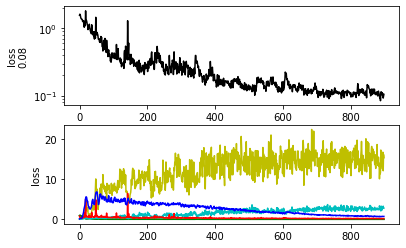

In [320]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True).to(device)
outfolder = "results/experiment_detach_lr4/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 900, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 6e-4)


  0%|          | 1/450 [00:01<09:55,  1.33s/it]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 1.5510 | lr: 0.0008 | n_subsample: 300] 
[Total time : 1.3269 | Iter: 1.3250 | fit: 0.2014 | reg: 0.1415 | save: 0.0000) | autograd: 0.9802]



 11%|█▏        | 51/450 [01:21<21:32,  3.24s/it]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 0.9906 | lr: 0.0008 | n_subsample: 378] 
[Total time : 81.6597 | Iter: 74.5625 | fit: 0.2410 | reg: 0.1932 | save: 5.7694) | autograd: 1.1091]



 22%|██▏       | 101/450 [02:50<19:47,  3.40s/it]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 0.6454 | lr: 0.0008 | n_subsample: 476] 
[Total time : 170.6861 | Iter: 83.5587 | fit: 0.2782 | reg: 0.2274 | save: 5.4664) | autograd: 1.2352]



 34%|███▎      | 151/450 [04:26<16:37,  3.34s/it]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 0.5883 | lr: 0.0008 | n_subsample: 600] 
[Total time : 266.5718 | Iter: 90.5091 | fit: 0.2711 | reg: 0.1802 | save: 5.3753) | autograd: 1.1535]



 45%|████▍     | 201/450 [06:05<14:34,  3.51s/it]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 0.4557 | lr: 0.0008 | n_subsample: 756] 
[Total time : 365.6039 | Iter: 93.5565 | fit: 0.3157 | reg: 0.1631 | save: 5.4716) | autograd: 1.2660]



 56%|█████▌    | 251/450 [07:47<11:41,  3.53s/it]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 0.5429 | lr: 0.0008 | n_subsample: 953] 
[Total time : 467.1369 | Iter: 95.8664 | fit: 0.2812 | reg: 0.2395 | save: 5.6644) | autograd: 1.4191]



 67%|██████▋   | 301/450 [09:30<08:58,  3.61s/it]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 0.4345 | lr: 0.0008 | n_subsample: 1100] 
[Total time : 570.7944 | Iter: 98.0678 | fit: 0.3073 | reg: 0.2498 | save: 5.5878) | autograd: 1.3629]



 78%|███████▊  | 351/450 [11:15<06:02,  3.66s/it]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 0.3318 | lr: 0.0008 | n_subsample: 1100] 
[Total time : 675.3579 | Iter: 98.8332 | fit: 0.2939 | reg: 0.2425 | save: 5.7281) | autograd: 1.3947]



 89%|████████▉ | 401/450 [12:55<02:57,  3.61s/it]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 0.1699 | lr: 0.0008 | n_subsample: 1100] 
[Total time : 775.0510 | Iter: 93.9689 | fit: 0.2925 | reg: 0.2598 | save: 5.7221) | autograd: 1.3549]



100%|██████████| 450/450 [14:31<00:00,  1.94s/it]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 0.1429 | lr: 0.0008 | n_subsample: 1100] 
[Total time : 871.7351 | Iter: 91.0624 | fit: 0.2843 | reg: 0.1934 | save: 5.6196) | autograd: 1.2683]



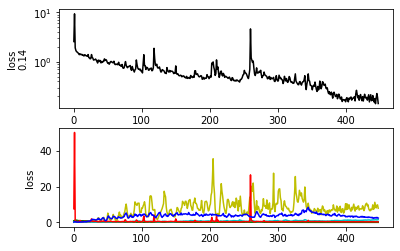

In [316]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = False).to(device)
outfolder = "results/experiment_debug_losses_no_detach_higherlr/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 450, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 8e-4)


  0%|          | 1/900 [00:01<20:35,  1.37s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 1.5276 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.3746 | Iter: 1.3728 | fit: 0.1998 | reg: 0.1391 | save: 0.0000) | autograd: 1.0317]



  6%|▌         | 51/900 [01:17<45:49,  3.24s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 1.1633 | lr: 0.0001 | n_subsample: 378] 
[Total time : 77.8683 | Iter: 70.8484 | fit: 0.2180 | reg: 0.1509 | save: 5.6433) | autograd: 1.0682]



 11%|█         | 101/900 [02:45<45:54,  3.45s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.9248 | lr: 0.0001 | n_subsample: 476] 
[Total time : 165.3472 | Iter: 81.6540 | fit: 0.2486 | reg: 0.1779 | save: 5.8217) | autograd: 1.2631]



 17%|█▋        | 151/900 [04:16<41:41,  3.34s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.7952 | lr: 0.0001 | n_subsample: 600] 
[Total time : 256.5703 | Iter: 85.7952 | fit: 0.2871 | reg: 0.2571 | save: 5.4253) | autograd: 1.2708]



 22%|██▏       | 201/900 [05:51<41:12,  3.54s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.6410 | lr: 0.0001 | n_subsample: 756] 
[Total time : 351.1438 | Iter: 88.6892 | fit: 0.2925 | reg: 0.2448 | save: 5.8821) | autograd: 1.3138]



 28%|██▊       | 251/900 [07:32<39:11,  3.62s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.5055 | lr: 0.0001 | n_subsample: 953] 
[Total time : 452.1297 | Iter: 95.2456 | fit: 0.3232 | reg: 0.2158 | save: 5.7384) | autograd: 1.2390]



 33%|███▎      | 301/900 [09:16<36:11,  3.63s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.4973 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 556.7918 | Iter: 99.1426 | fit: 0.3492 | reg: 0.2795 | save: 5.5177) | autograd: 1.4918]



 39%|███▉      | 351/900 [11:04<34:53,  3.81s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.4517 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 664.7805 | Iter: 102.1788 | fit: 0.3430 | reg: 0.2893 | save: 5.8077) | autograd: 1.4932]



 45%|████▍     | 401/900 [12:55<32:11,  3.87s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.4173 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 775.8671 | Iter: 105.2059 | fit: 0.3574 | reg: 0.2619 | save: 5.8788) | autograd: 1.4533]



 50%|█████     | 451/900 [14:46<27:47,  3.71s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.4023 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 886.9259 | Iter: 105.6411 | fit: 0.3345 | reg: 0.3091 | save: 5.4156) | autograd: 1.5277]



 56%|█████▌    | 501/900 [16:39<26:08,  3.93s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.4012 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 999.3128 | Iter: 106.4046 | fit: 0.3408 | reg: 0.3088 | save: 5.9798) | autograd: 1.5559]



 61%|██████    | 551/900 [18:32<23:51,  4.10s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3741 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 1112.8831 | Iter: 107.2883 | fit: 0.3564 | reg: 0.2668 | save: 6.2798) | autograd: 1.5722]



 67%|██████▋   | 601/900 [20:28<21:22,  4.29s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3552 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 1228.3103 | Iter: 108.4427 | fit: 0.3758 | reg: 0.3124 | save: 6.9764) | autograd: 1.5711]



 72%|███████▏  | 651/900 [22:19<16:04,  3.87s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3282 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 1339.2439 | Iter: 104.8254 | fit: 0.3539 | reg: 0.2256 | save: 6.1060) | autograd: 1.4492]



 78%|███████▊  | 701/900 [24:12<13:06,  3.95s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3434 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 1452.1265 | Iter: 106.8682 | fit: 0.3299 | reg: 0.2972 | save: 6.0129) | autograd: 1.6024]



 83%|████████▎ | 751/900 [26:03<09:47,  3.94s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3347 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 1563.5763 | Iter: 105.4301 | fit: 0.3319 | reg: 0.2823 | save: 6.0187) | autograd: 1.5706]



 89%|████████▉ | 801/900 [27:56<06:43,  4.07s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3155 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 1676.2257 | Iter: 106.3352 | fit: 0.3510 | reg: 0.2687 | save: 6.3124) | autograd: 1.4983]



 95%|█████████▍| 851/900 [29:47<03:11,  3.92s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3107 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 1787.6416 | Iter: 105.5427 | fit: 0.3653 | reg: 0.3019 | save: 5.8717) | autograd: 1.4601]



100%|██████████| 900/900 [31:36<00:00,  2.11s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3103 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 1896.1793 | Iter: 102.6719 | fit: 0.3179 | reg: 0.2817 | save: 5.8635) | autograd: 1.5738]




  0%|          | 1/900 [00:00<11:15,  1.33it/s]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 1.5584 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.7530 | Iter: 0.7519 | fit: 0.2043 | reg: 0.1745 | save: 0.0000) | autograd: 0.3699]



  6%|▌         | 51/900 [00:41<35:35,  2.52s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 1.2196 | lr: 0.0001 | n_subsample: 378] 
[Total time : 41.9132 | Iter: 35.2441 | fit: 0.1985 | reg: 0.1413 | save: 5.9146) | autograd: 0.4024]



 11%|█         | 101/900 [01:29<35:27,  2.66s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 1.0193 | lr: 0.0001 | n_subsample: 476] 
[Total time : 89.2864 | Iter: 41.4077 | fit: 0.2359 | reg: 0.1930 | save: 5.9639) | autograd: 0.4475]



 17%|█▋        | 151/900 [02:20<33:30,  2.68s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.8368 | lr: 0.0001 | n_subsample: 600] 
[Total time : 140.2052 | Iter: 45.0659 | fit: 0.2525 | reg: 0.1458 | save: 5.8509) | autograd: 0.4792]



 22%|██▏       | 201/900 [03:16<35:42,  3.06s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.6238 | lr: 0.0001 | n_subsample: 756] 
[Total time : 196.2515 | Iter: 49.2824 | fit: 0.2759 | reg: 0.2151 | save: 6.7615) | autograd: 0.5550]



 28%|██▊       | 251/900 [04:17<31:59,  2.96s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.2905 | lr: 0.0001 | n_subsample: 953] 
[Total time : 257.6602 | Iter: 55.3656 | fit: 0.3100 | reg: 0.2511 | save: 6.0411) | autograd: 0.6382]



 33%|███▎      | 301/900 [05:20<29:14,  2.93s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.2269 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 320.4175 | Iter: 56.9218 | fit: 0.3128 | reg: 0.2557 | save: 5.8342) | autograd: 0.6621]



 39%|███▉      | 351/900 [06:23<25:19,  2.77s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1935 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 383.2304 | Iter: 57.4262 | fit: 0.2965 | reg: 0.1917 | save: 5.3839) | autograd: 0.5893]



 45%|████▍     | 401/900 [07:26<23:24,  2.81s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1793 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 446.1685 | Iter: 57.2720 | fit: 0.2909 | reg: 0.2319 | save: 5.6650) | autograd: 0.6042]



 50%|█████     | 451/900 [08:29<22:01,  2.94s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1686 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 509.8763 | Iter: 57.7131 | fit: 0.2960 | reg: 0.2205 | save: 5.9927) | autograd: 0.5907]



 56%|█████▌    | 501/900 [09:34<19:15,  2.89s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1690 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 574.3994 | Iter: 58.6028 | fit: 0.3170 | reg: 0.1756 | save: 5.9190) | autograd: 0.6052]



 61%|██████    | 551/900 [10:40<18:47,  3.23s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1650 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 640.2876 | Iter: 59.2890 | fit: 0.3151 | reg: 0.2402 | save: 6.5984) | autograd: 0.6924]



 67%|██████▋   | 601/900 [11:44<14:01,  2.81s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1578 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 704.2851 | Iter: 58.4717 | fit: 0.2995 | reg: 0.2330 | save: 5.5248) | autograd: 0.6221]



 72%|███████▏  | 651/900 [12:48<11:48,  2.85s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1699 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 768.3896 | Iter: 58.4737 | fit: 0.2935 | reg: 0.2566 | save: 5.6294) | autograd: 0.6348]



 78%|███████▊  | 701/900 [13:51<09:29,  2.86s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.2251 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 831.5844 | Iter: 57.4301 | fit: 0.2991 | reg: 0.1960 | save: 5.7628) | autograd: 0.5811]



 83%|████████▎ | 751/900 [14:55<07:12,  2.90s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1368 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 895.6179 | Iter: 58.2838 | fit: 0.3047 | reg: 0.2721 | save: 5.7468) | autograd: 0.6922]



 89%|████████▉ | 801/900 [16:02<04:57,  3.00s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1341 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 962.1501 | Iter: 60.5036 | fit: 0.3260 | reg: 0.2262 | save: 6.0260) | autograd: 0.7248]



 95%|█████████▍| 851/900 [17:07<02:32,  3.11s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1289 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 1027.7896 | Iter: 59.3817 | fit: 0.3295 | reg: 0.2615 | save: 6.2555) | autograd: 0.7072]



100%|██████████| 900/900 [18:10<00:00,  1.21s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1402 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 1090.8867 | Iter: 57.3173 | fit: 0.3051 | reg: 0.2794 | save: 5.7773) | autograd: 0.6912]



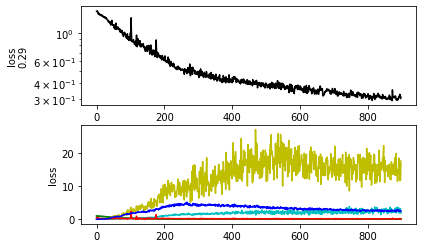

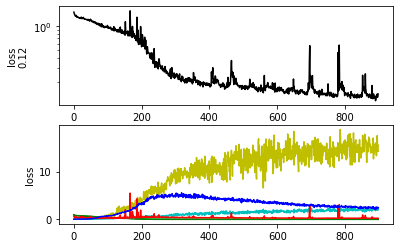

In [297]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = False).to(device)
outfolder = "results/experiment_debug_losses_no_detach/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 900, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, clipnorms = True)

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = False).to(device)
outfolder = "results/experiment_debug_losses_detach/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 900, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = True, clipnorms = True)


In [201]:
import Utils; importlib.reload(Utils); from Utils import SaveTrajectory as st
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));
model = FfjordModel(sigmac = 3.5, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True).to(device)
model.load_state("results/experiment_radial/models/state_final.tar")
x_trajs = st.save_trajectory(model, keyframes, savename='save_debug', nsteps=20, dpiv=400, n=1000, alpha=1, ot_type=1, writeTracers=True)

In [23]:
# establish some baselines. with regularizers and small weight. ~450s for 200 iters.
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, initzero = False).to(device)
outfolder = "results/experiment_base/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 200, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True)


  0%|          | 1/200 [00:00<03:10,  1.05it/s]

Allocated: 0.03 GB  Reserved: 0.34 GB
[Loss: 1000.0000 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.9565 | Iter: 0.9548 | fit: 0.1575 | reg: 0.0968 | save: 0.0000) | autograd: 0.6982]


  2%|▏         | 4/200 [00:05<04:05,  1.25s/it]


KeyboardInterrupt: 